In [4]:
import numpy as np

def design_fir_lowpass(num_taps, cutoff_freq, sample_rate, window_func=np.hamming):
    """
    Designs FIR low-pass filter coefficients using the windowing method.

    Args:
        num_taps (int): Number of filter coefficients (taps).
        cutoff_freq (float): Cutoff frequency in Hz.
        sample_rate (float): Sampling rate in Hz.
        window_func (callable): Window function to apply (e.g., np.hamming, np.blackman).

    Returns:
        numpy.ndarray: Array of filter coefficients.
    """
    nyquist_freq = 0.5 * sample_rate
    normalized_cutoff = cutoff_freq / nyquist_freq

    # Create ideal low-pass filter impulse response (sinc function)
    t = np.arange(num_taps) - (num_taps - 1) / 2
    h_ideal = np.sinc(2 * normalized_cutoff * t)

    # Apply window function
    window = window_func(num_taps)
    h = h_ideal * window

    # Normalize coefficients to ensure unity gain at DC
    h /= np.sum(h)
    return h

$$
y[n] = \sum
$$

In [5]:
def apply_fir_filter(signal, filter_coefficients):
    """
    Applies an FIR filter to a signal using convolution.

    Args:
        signal (numpy.ndarray): Input signal.
        filter_coefficients (numpy.ndarray): FIR filter coefficients.

    Returns:
        numpy.ndarray: Filtered signal.
    """
    return np.convolve(signal, filter_coefficients, mode='valid')

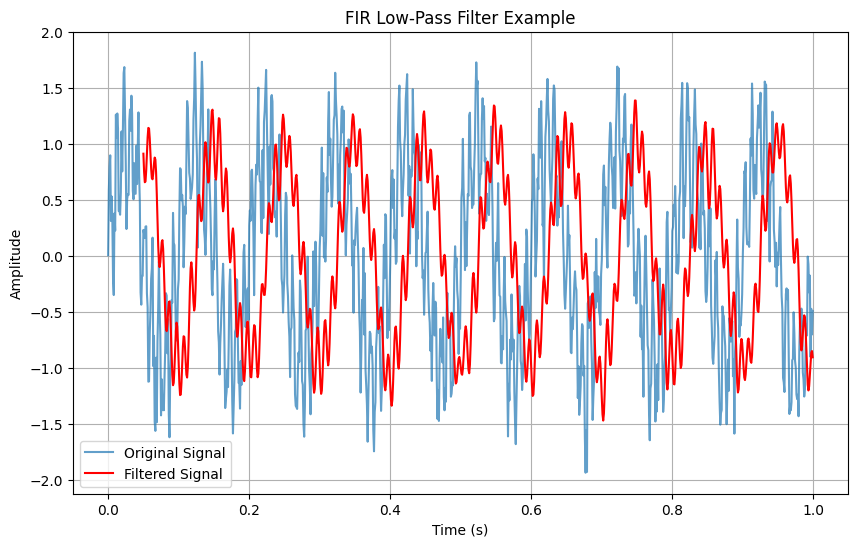

In [6]:
import matplotlib.pyplot as plt

# Generate a test signal
sample_rate = 1000  # Hz
duration = 1.0      # seconds
t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
signal = np.sin(2 * np.pi * 10 * t) + 0.5 * np.sin(2 * np.pi * 100 * t) + 0.2 * np.random.randn(len(t))

# Design the filter
num_taps = 51
cutoff_freq = 50  # Hz
fir_coefficients = design_fir_lowpass(num_taps, cutoff_freq, sample_rate)

# Apply the filter
filtered_signal = apply_fir_filter(signal, fir_coefficients)

# Plotting results
plt.figure(figsize=(10, 6))
plt.plot(t, signal, label='Original Signal', alpha=0.7)
# Adjust time axis for filtered signal due to 'valid' mode in convolve
plt.plot(t[num_taps-1:], filtered_signal, label='Filtered Signal', color='red')
plt.title('FIR Low-Pass Filter Example')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
fir_coefficients

array([ 6.22233219e-19,  6.50395537e-04,  1.24025458e-03,  1.54168857e-03,
        1.21680726e-03, -1.30554005e-18, -2.01071740e-03, -4.14071058e-03,
       -5.21455172e-03, -4.01474662e-03,  3.09446055e-18,  6.05036949e-03,
        1.18742206e-02,  1.43176216e-02,  1.06257168e-02, -5.30568790e-18,
       -1.52613457e-02, -2.96911186e-02, -3.59490768e-02, -2.72307378e-02,
        7.09460841e-18,  4.40087761e-02,  9.74197266e-02,  1.48825236e-01,
        1.85978564e-01,  1.99527255e-01,  1.85978564e-01,  1.48825236e-01,
        9.74197266e-02,  4.40087761e-02,  7.09460841e-18, -2.72307378e-02,
       -3.59490768e-02, -2.96911186e-02, -1.52613457e-02, -5.30568790e-18,
        1.06257168e-02,  1.43176216e-02,  1.18742206e-02,  6.05036949e-03,
        3.09446055e-18, -4.01474662e-03, -5.21455172e-03, -4.14071058e-03,
       -2.01071740e-03, -1.30554005e-18,  1.21680726e-03,  1.54168857e-03,
        1.24025458e-03,  6.50395537e-04,  6.22233219e-19])

In [10]:
def float_to_fixed_point(coeffs, int_bits=1, frac_bits=15):
    """
    Convert floating-point coefficients to 16-bit fixed-point representation.
    
    Args:
        coeffs (numpy.ndarray): Floating-point coefficients
        int_bits (int): Number of integer bits (default: 1 for sign + 0 integer bits)
        frac_bits (int): Number of fractional bits (default: 15)
    
    Returns:
        tuple: (fixed_point_coeffs, scale_factor)
            - fixed_point_coeffs: 16-bit signed integer array
            - scale_factor: scaling factor used (2^frac_bits)
    """
    # Calculate scale factor
    scale_factor = 2**frac_bits
    
    # Scale and round to nearest integer
    scaled_coeffs = np.round(coeffs * scale_factor).astype(np.int16)
    
    # Check for overflow
    max_val = 2**(15) - 1  # Maximum positive value for 16-bit signed
    min_val = -2**(15)     # Maximum negative value for 16-bit signed
    
    if np.any(scaled_coeffs > max_val) or np.any(scaled_coeffs < min_val):
        print(f"Warning: Coefficients overflow 16-bit range!")
        print(f"Max coefficient: {np.max(scaled_coeffs)}, Min coefficient: {np.min(scaled_coeffs)}")
        # Clip to valid range
        scaled_coeffs = np.clip(scaled_coeffs, min_val, max_val)
    
    return scaled_coeffs, scale_factor

# Convert coefficients to 16-bit fixed point (Q1.15 format)
fixed_coeffs, scale = float_to_fixed_point(fir_coefficients)

print(f"Scale factor: {scale}")
print(f"Fixed-point coefficients (16-bit signed integers):")
print(fixed_coeffs)
print(f"\nCoefficient range: {np.min(fixed_coeffs)} to {np.max(fixed_coeffs)}")

# Verify conversion by converting back to float
recovered_coeffs = fixed_coeffs.astype(np.float64) / scale
max_error = np.max(np.abs(fir_coefficients - recovered_coeffs))
print(f"Maximum quantization error: {max_error:.2e}")

Scale factor: 32768
Fixed-point coefficients (16-bit signed integers):
[    0    21    41    51    40     0   -66  -136  -171  -132     0   198
   389   469   348     0  -500  -973 -1178  -892     0  1442  3192  4877
  6094  6538  6094  4877  3192  1442     0  -892 -1178  -973  -500     0
   348   469   389   198     0  -132  -171  -136   -66     0    40    51
    41    21     0]

Coefficient range: -1178 to 6538
Maximum quantization error: 1.47e-05


In [13]:
def export_coefficients_for_hardware(fixed_coeffs, format_type='verilog'):
    """
    Export fixed-point coefficients in various hardware-friendly formats.
    
    Args:
        fixed_coeffs (numpy.ndarray): 16-bit fixed-point coefficients
        format_type (str): Output format - 'verilog', 'c_array', 'hex', 'binary'
    
    Returns:
        str: Formatted coefficient string
    """
    if format_type == 'verilog':
        # SystemVerilog array format
        coeffs_str = "parameter logic signed [15:0] fir_coeffs[0:{}] = '{{\n".format(len(fixed_coeffs)-1)
        for i, coeff in enumerate(fixed_coeffs):
            # Convert to Python int to avoid overflow issues
            coeff_int = int(coeff)
            # Convert to unsigned 16-bit representation for hex display
            if coeff_int >= 0:
                unsigned_val = coeff_int
            else:
                unsigned_val = coeff_int + 65536  # Two's complement conversion
            hex_val = f"16'h{unsigned_val:04X}"
            coeffs_str += f"    {hex_val}" + ("," if i < len(fixed_coeffs)-1 else "") + f"  // {coeff_int}\n"
        coeffs_str += "};"
        return coeffs_str
    
    elif format_type == 'c_array':
        # C array format
        coeffs_str = "const int16_t fir_coeffs[] = {\n"
        for i, coeff in enumerate(fixed_coeffs):
            coeffs_str += f"    {int(coeff)}" + ("," if i < len(fixed_coeffs)-1 else "") + "\n"
        coeffs_str += "};"
        return coeffs_str
    
    elif format_type == 'hex':
        # Hex values only
        hex_values = []
        for coeff in fixed_coeffs:
            coeff_int = int(coeff)
            if coeff_int >= 0:
                hex_values.append(f"0x{coeff_int:04X}")
            else:
                unsigned_val = coeff_int + 65536
                hex_values.append(f"0x{unsigned_val:04X}")
        return ", ".join(hex_values)
    
    elif format_type == 'binary':
        # Binary format (16-bit two's complement)
        binary_values = []
        for coeff in fixed_coeffs:
            coeff_int = int(coeff)
            if coeff_int >= 0:
                binary_values.append(f"{coeff_int:016b}")
            else:
                unsigned_val = coeff_int + 65536
                binary_values.append(f"{unsigned_val:016b}")
        return "\n".join(binary_values)

# Generate different formats
print("=== SystemVerilog Format ===")
print(export_coefficients_for_hardware(fixed_coeffs, 'verilog'))

print("\n=== C Array Format ===")
print(export_coefficients_for_hardware(fixed_coeffs, 'c_array'))

print(f"\n=== Hex Format ===")
print(export_coefficients_for_hardware(fixed_coeffs, 'hex'))

=== SystemVerilog Format ===
parameter logic signed [15:0] fir_coeffs[0:50] = '{
    16'h0000,  // 0
    16'h0015,  // 21
    16'h0029,  // 41
    16'h0033,  // 51
    16'h0028,  // 40
    16'h0000,  // 0
    16'hFFBE,  // -66
    16'hFF78,  // -136
    16'hFF55,  // -171
    16'hFF7C,  // -132
    16'h0000,  // 0
    16'h00C6,  // 198
    16'h0185,  // 389
    16'h01D5,  // 469
    16'h015C,  // 348
    16'h0000,  // 0
    16'hFE0C,  // -500
    16'hFC33,  // -973
    16'hFB66,  // -1178
    16'hFC84,  // -892
    16'h0000,  // 0
    16'h05A2,  // 1442
    16'h0C78,  // 3192
    16'h130D,  // 4877
    16'h17CE,  // 6094
    16'h198A,  // 6538
    16'h17CE,  // 6094
    16'h130D,  // 4877
    16'h0C78,  // 3192
    16'h05A2,  // 1442
    16'h0000,  // 0
    16'hFC84,  // -892
    16'hFB66,  // -1178
    16'hFC33,  // -973
    16'hFE0C,  // -500
    16'h0000,  // 0
    16'h015C,  // 348
    16'h01D5,  // 469
    16'h0185,  // 389
    16'h00C6,  // 198
    16'h0000,  // 0
    16'hFF7C,  

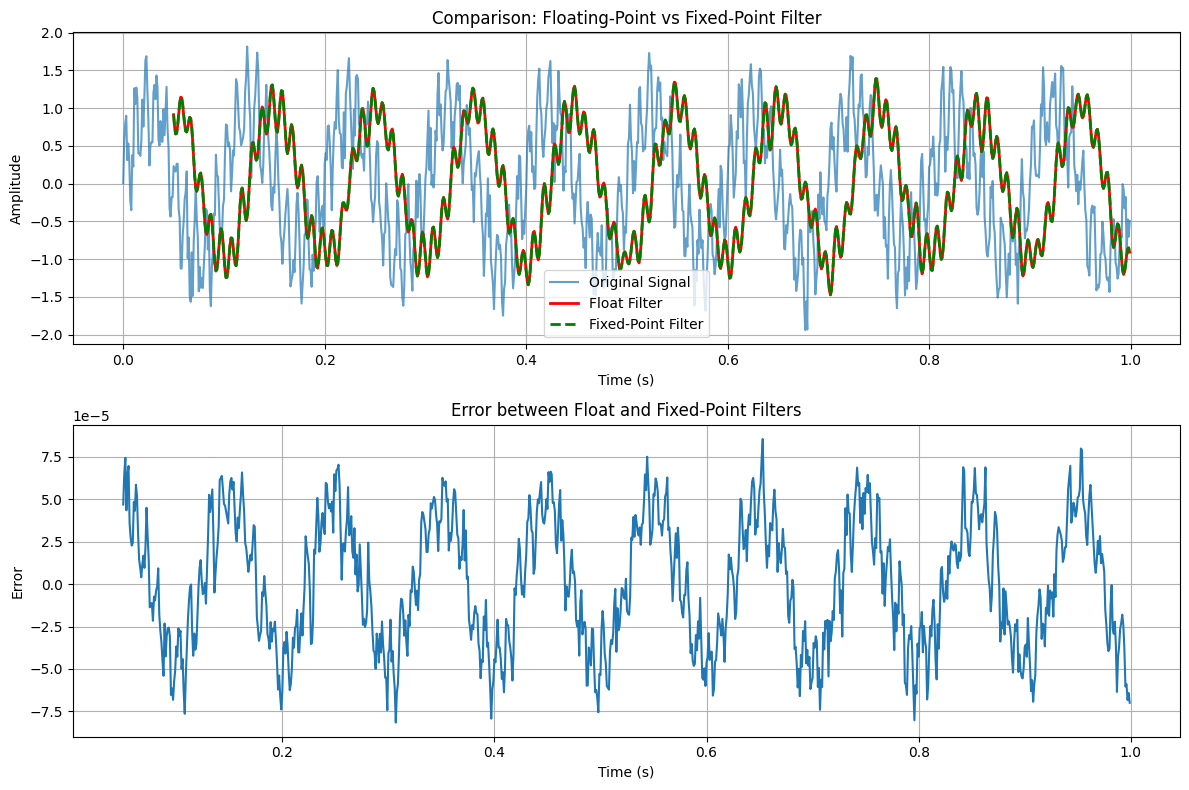

Maximum error between float and fixed-point filters: 8.56e-05
RMS error: 3.74e-05


In [14]:
def apply_fixed_point_filter(signal, fixed_coeffs, scale_factor):
    """
    Apply fixed-point FIR filter to a signal.
    
    Args:
        signal (numpy.ndarray): Input signal
        fixed_coeffs (numpy.ndarray): Fixed-point filter coefficients
        scale_factor (float): Scale factor used in fixed-point conversion
    
    Returns:
        numpy.ndarray: Filtered signal (converted back to floating point)
    """
    # Convert signal to fixed-point (simulate ADC)
    signal_fixed = np.round(signal * scale_factor).astype(np.int32)
    
    # Apply convolution using fixed-point arithmetic
    filtered_fixed = np.convolve(signal_fixed, fixed_coeffs.astype(np.int32), mode='valid')
    
    # Convert back to floating point (simulate DAC)
    # Note: We divide by scale_factor twice because both signal and coeffs were scaled
    filtered_float = filtered_fixed.astype(np.float64) / (scale_factor * scale_factor)
    
    return filtered_float

# Test the fixed-point filter
fixed_filtered = apply_fixed_point_filter(signal, fixed_coeffs, scale)
float_filtered = apply_fir_filter(signal, fir_coefficients)

# Compare results
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(t, signal, label='Original Signal', alpha=0.7)
plt.plot(t[num_taps-1:], float_filtered, label='Float Filter', color='red', linewidth=2)
plt.plot(t[num_taps-1:], fixed_filtered, label='Fixed-Point Filter', color='green', linestyle='--', linewidth=2)
plt.title('Comparison: Floating-Point vs Fixed-Point Filter')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
error = float_filtered - fixed_filtered
plt.plot(t[num_taps-1:], error)
plt.title('Error between Float and Fixed-Point Filters')
plt.xlabel('Time (s)')
plt.ylabel('Error')
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Maximum error between float and fixed-point filters: {np.max(np.abs(error)):.2e}")
print(f"RMS error: {np.sqrt(np.mean(error**2)):.2e}")

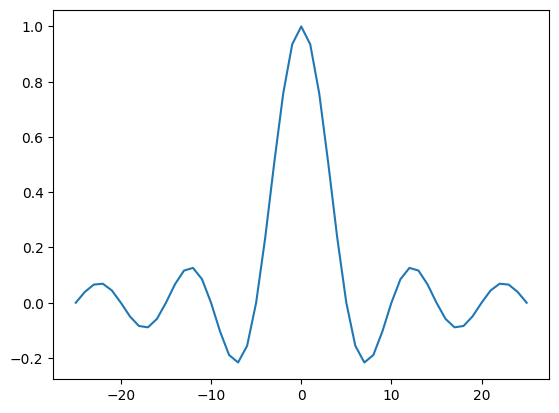

In [8]:
def plot_ideal(num_taps, cutoff_freq, sample_rate, window_func=np.hamming):
    """
    Designs FIR low-pass filter coefficients using the windowing method.

    Args:
        num_taps (int): Number of filter coefficients (taps).
        cutoff_freq (float): Cutoff frequency in Hz.
        sample_rate (float): Sampling rate in Hz.
        window_func (callable): Window function to apply (e.g., np.hamming, np.blackman).

    Returns:
        numpy.ndarray: Array of filter coefficients.
    """
    nyquist_freq = 0.5 * sample_rate
    normalized_cutoff = cutoff_freq / nyquist_freq

    # Create ideal low-pass filter impulse response (sinc function)
    t = np.arange(num_taps) - (num_taps - 1) / 2
    h_ideal = np.sinc(2 * normalized_cutoff * t)
    
    plt.plot(t,h_ideal)

plot_ideal(num_taps, cutoff_freq, sample_rate)